In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq
import matplotlib.pyplot as plt


def roc_auc(labels, scores, show=False):
    """Compute ROC curve and ROC area for each class"""
    
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    if show:
        
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        plt.figure()
        lw = 2
        plt.plot(fpr,
                 tpr,
                 color='darkorange',
                 lw=lw,
                 label='(AUC = %0.2f, EER = %0.2f)' % (roc_auc, eer))
        plt.plot([eer], [1 - eer], marker='o', markersize=5, color="navy")
        plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_auc.png")
        plt.show()
#         plt.close()
    return {'roc_auc': roc_auc}


def pre_rec_curve(labels, scores, show=False):
    average_precision = average_precision_score(labels, scores)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    if show:
        precision, recall, _ = precision_recall_curve(labels, scores)
        step_kwargs = ({
            'step': 'post'
        } if 'step' in signature(plt.fill_between).parameters else {})
        plt.figure()
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall,
                         precision,
                         alpha=0.2,
                         color='b',
                         **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
        plt.savefig("pre_rec_curve.png")
        plt.show()
#         plt.close()
    return {'average_precision': average_precision}


In [ ]:
import time
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from absl import logging


class Conv_BN_Act(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 ks,
                 act_type,
                 is_bn=True,
                 padding='same',
                 strides=1,
                 conv_tran=False):
        super(Conv_BN_Act, self).__init__()
        if conv_tran:
            self.conv = layers.Conv2DTranspose(filters,
                                               ks,
                                               strides=strides,
                                               padding=padding,
                                               use_bias=False)
        else:
            self.conv = layers.Conv2D(filters,
                                      ks,
                                      strides=strides,
                                      padding=padding,
                                      use_bias=False)

        self.is_bn = is_bn
        if is_bn:
            self.bn = layers.BatchNormalization(epsilon=1e-05, momentum=0.9)

        if act_type == 'LeakyReLU':
            self.act = layers.LeakyReLU(alpha=0.2)
            self.erase_act = False
        elif act_type == 'ReLU':
            self.act = layers.ReLU()
            self.erase_act = False
        elif act_type == 'Tanh':
            self.act = layers.Activation(tf.tanh)
            self.erase_act = False
        elif act_type == '':
            self.erase_act = True
        else:
            raise ValueError

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x) if self.is_bn else x
        x = x if self.erase_act else self.act(x)
        return x


class Encoder(tf.keras.layers.Layer):
    """ DCGAN ENCODER NETWORK
    """
    def __init__(self,
                 isize,
                 nz,
                 nc,
                 ndf,
                 n_extra_layers=0,
                 output_features=False):

        super(Encoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.in_block = Conv_BN_Act(filters=ndf,
                                    ks=4,
                                    act_type='LeakyReLU',
                                    is_bn=False,
                                    strides=2)
        csize, cndf = isize / 2, ndf

        self.extra_blocks = []
        for t in range(n_extra_layers):
            extra = Conv_BN_Act(filters=cndf, ks=3, act_type='LeakyReLU')
            self.extra_blocks.append(extra)

        self.body_blocks = []
        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            body = Conv_BN_Act(filters=out_feat,
                               ks=4,
                               act_type='LeakyReLU',
                               strides=2)
            self.body_blocks.append(body)
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        self.output_features = output_features
        self.out_conv = layers.Conv2D(filters=nz,
                                      kernel_size=4,
                                      padding='valid')

    def call(self, x):
        x = self.in_block(x)
        for block in self.extra_blocks:
            x = block(x)
        for block in self.body_blocks:
            x = block(x)
        last_features = x
        out = self.out_conv(last_features)
        if self.output_features:
            return out, last_features
        else:
            return out


class DenseEncoder(tf.keras.layers.Layer):
    def __init__(self, layer_dims, out_size=None, output_features=False, hidden_activation="selu", p_dropout=.2):

        super(DenseEncoder, self).__init__()

        # Config
        self.output_features = output_features

        # Layers
        self.in_block = tf.keras.layers.Dense(layer_dims[0], activation=hidden_activation)
        self.body_blocks = []
        self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))
        for cur_dim in layer_dims[1:-1]:
            self.body_blocks.append(tf.keras.layers.Dense(cur_dim, activation=hidden_activation))
            self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))

        # Override the output dimension if given
        if out_size is not None:
            self.out_act = tf.keras.layers.Dense(out_size)
        else:
            self.out_act = tf.keras.layers.Dense(layer_dims[-1])

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        last_features = x
        out = self.out_act(last_features)
        if self.output_features:
            return out, last_features
        else:
            return out


class Decoder(tf.keras.layers.Layer):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):

        super(Decoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"
        cngf, tisize = ngf // 2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        self.in_block = Conv_BN_Act(filters=cngf,
                                    ks=4,
                                    act_type='ReLU',
                                    padding='valid',
                                    conv_tran=True)

        csize, _ = 4, cngf
        self.body_blocks = []
        while csize < isize // 2:
            body = Conv_BN_Act(filters=cngf // 2,
                               ks=4,
                               act_type='ReLU',
                               strides=2,
                               conv_tran=True)
            self.body_blocks.append(body)
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        self.extra_blocks = []
        for t in range(n_extra_layers):
            extra = Conv_BN_Act(filters=cngf,
                                ks=3,
                                act_type='ReLU',
                                conv_tran=True)
            self.extra_blocks.append(extra)

        self.out_block = Conv_BN_Act(filters=nc,
                                     ks=4,
                                     act_type='Tanh',
                                     strides=2,
                                     is_bn=False,
                                     conv_tran=True)

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        for block in self.extra_blocks:
            x = block(x)
        x = self.out_block(x)
        return x


class DenseDecoder(tf.keras.layers.Layer):
    def __init__(self, isize, layer_dims, hidden_activation="selu", p_dropout=.2):

        super(DenseDecoder, self).__init__()

        # Layers
        self.in_block = tf.keras.layers.Dense(layer_dims[0], activation=hidden_activation)
        self.body_blocks = []
        self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))
        for cur_dim in layer_dims[1:]:
            self.body_blocks.append(tf.keras.layers.Dense(cur_dim, activation=hidden_activation))
            self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))

        self.out_block = tf.keras.layers.Dense(isize, activation="tanh")

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        x = self.out_block(x)
        return x


class NetG(tf.keras.Model):
    def __init__(self, opt):
        super(NetG, self).__init__()

        # Use the dense encoder-decoder pair when the dimensions are given
        if opt.encdims:
            self.encoder1 = DenseEncoder(opt.encdims)
            self.decoder = DenseDecoder(opt.isize, tuple(reversed(opt.encdims[:-1])))
            self.encoder2 = DenseEncoder(opt.encdims)
        else:
            self.encoder1 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)
            self.decoder = Decoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)
            self.encoder2 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)

    def call(self, x):
        latent_i = self.encoder1(x)
        gen_img = self.decoder(latent_i)
        latent_o = self.encoder2(gen_img)
        return latent_i, gen_img, latent_o

    def num_params(self):
        return sum(
            [np.prod(var.shape.as_list()) for var in self.trainable_variables])


class NetD(tf.keras.Model):
    """ DISCRIMINATOR NETWORK
    """
    def __init__(self, opt):
        super(NetD, self).__init__()

        # Use the dense encoder when the dimensions are given
        if opt.encdims:
            self.encoder = DenseEncoder(opt.encdims, out_size=1, output_features=True)
        else:
            self.encoder = Encoder(opt.isize, 1, opt.nc, opt.ngf, opt.extralayers, output_features=True)

        self.sigmoid = layers.Activation(tf.sigmoid)

    def call(self, x):
        output, last_features = self.encoder(x)
        output = self.sigmoid(output)
        return output, last_features


class GANRunner:
    def __init__(self,
                 G,
                 D,
                 best_state_key,
                 best_state_policy,
                 train_dataset,
                 valid_dataset=None,
                 test_dataset=None,
                 save_path='ckpt/'):
        self.G = G
        self.D = D
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.num_ele_train = self._get_num_element(self.train_dataset)
        self.best_state_key = best_state_key
        self.best_state_policy = best_state_policy
        self.best_state = 1e-9 if self.best_state_policy == max else 1e9
        self.save_path = save_path

    def train_step(self, x, y):
        raise NotImplementedError

    def validate_step(self, x, y):
        raise NotImplementedError

    def evaluate(self, x):
        raise NotImplementedError

    def _get_num_element(self, dataset):
        num_elements = 0
        for _ in dataset:
            num_elements += 1
        return num_elements

    def fit(self, num_epoch, best_state_ths=None):
        self.best_state = self.best_state_policy(
            self.best_state,
            best_state_ths) if best_state_ths is not None else self.best_state
        for epoch in range(num_epoch):
            start_time = time.time()
            # train one epoch
            G_losses = []
            D_losses = []
            with tqdm(total=self.num_ele_train, leave=False) as pbar:
                for step, (x_batch_train,
                           y_batch_train) in enumerate(self.train_dataset):
                    loss = self.train_step(x_batch_train, y_batch_train)
                    G_losses.append(loss[0].numpy())
                    D_losses.append(loss[1].numpy())
                    pbar.update(1)
                G_losses = np.array(G_losses).mean()
                D_losses = np.array(D_losses).mean()
                speed = step * len(x_batch_train) / (time.time() - start_time)
                logging.info(
                    'epoch: {}, G_losses: {:.4f}, D_losses: {:.4f}, samples/sec: {:.4f}'
                    .format(epoch, G_losses, D_losses, speed))

            # validate one epoch
            if self.valid_dataset is not None:
                G_losses = []
                D_losses = []
                for step, (x_batch_train,
                           y_batch_train) in enumerate(self.valid_dataset):
                    loss = self.validate_step(x_batch_train, y_batch_train)
                    G_losses.append(loss[0].numpy())
                    D_losses.append(loss[1].numpy())
                G_losses = np.array(G_losses).mean()
                D_losses = np.array(D_losses).mean()
                logging.info(
                    '\t Validating: G_losses: {}, D_losses: {}'.format(
                        G_losses, D_losses))

            
            if self.test_dataset is not None:
                dict_ = self.evaluate(self.test_dataset)
                log_str = '\t Testing:'
                for k, v in dict_.items():
                    log_str = log_str + '   {}: {:.4f}'.format(k, v)
                state_value = dict_[self.best_state_key]
                self.best_state = self.best_state_policy(
                    self.best_state, state_value)
                if self.best_state == state_value:
                    log_str = '*** ' + log_str + ' ***'
                    self.save_best()
                logging.info(log_str)

    def save(self, path):
        self.G.save_weights(self.save_path + 'G')
        self.D.save_weights(self.save_path + 'D')

    def load(self, path):
        self.G.load_weights(self.save_path + 'G')
        self.D.load_weights(self.save_path + 'D')

    def save_best(self):
        self.save(self.save_path + 'best')

    def load_best(self):
        self.load(self.save_path + 'best')


class GANomaly(GANRunner):
    def __init__(self,
                 opt,
                 train_dataset,
                 valid_dataset=None,
                 test_dataset=None):
        self.opt = opt
        self.G = NetG(self.opt)
        self.D = NetD(self.opt)
        super(GANomaly, self).__init__(self.G,
                                       self.D,
                                       best_state_key='roc_auc',
                                       best_state_policy=max,
                                       train_dataset=train_dataset,
                                       valid_dataset=valid_dataset,
                                       test_dataset=test_dataset)
        self.D(tf.keras.Input(shape=[opt.isize] if opt.encdims else [opt.isize, opt.isize, opt.nc]))
        self.D_init_w_path = '/tmp/D_init'
        self.D.save_weights(self.D_init_w_path)

        
        self.real_label = tf.ones([
            self.opt.batch_size,
        ], dtype=tf.float32)
        self.fake_label = tf.zeros([
            self.opt.batch_size,
        ], dtype=tf.float32)

        
        l2_loss = tf.keras.losses.MeanSquaredError()
        l1_loss = tf.keras.losses.MeanAbsoluteError()
        bce_loss = tf.keras.losses.BinaryCrossentropy()

        
        self.d_optimizer = tf.keras.optimizers.Adam(self.opt.lr,
                                                    beta_1=self.opt.beta1,
                                                    beta_2=0.999)
        self.g_optimizer = tf.keras.optimizers.Adam(self.opt.lr,
                                                    beta_1=self.opt.beta1,
                                                    beta_2=0.999)

        # adversarial loss (use feature matching)
        self.l_adv = l2_loss
        # contextual loss
        self.l_con = l1_loss
        # Encoder loss
        self.l_enc = l2_loss
        # discriminator loss
        self.l_bce = bce_loss

    def _evaluate(self, test_dataset):
        an_scores = []
        gt_labels = []
        for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
            latent_i, gen_img, latent_o = self.G(x_batch_train)
            latent_i, gen_img, latent_o = latent_i.numpy(), gen_img.numpy(
            ), latent_o.numpy()
            error = np.mean((latent_i - latent_o)**2, axis=-1)
            an_scores.append(error)
            gt_labels.append(y_batch_train)
        an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
        gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
        return an_scores, gt_labels

    def evaluate(self, test_dataset):
        ret_dict = {}
        an_scores, gt_labels = self._evaluate(test_dataset)
        # normed to [0,1)
        an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) -
                                                        np.amin(an_scores))
        # AUC
        auc_dict = roc_auc(gt_labels, an_scores)
        ret_dict.update(auc_dict)
        # Average Precision
        p_r_dict = pre_rec_curve(gt_labels, an_scores)
        ret_dict.update(p_r_dict)
        return ret_dict

    def evaluate_best(self, test_dataset):
        self.load_best()
        an_scores, gt_labels = self._evaluate(test_dataset)
        # AUC
        _ = roc_auc(gt_labels, an_scores, show=True)
        # Average Precision
        _ = pre_rec_curve(gt_labels, an_scores, show=True)

    @tf.function
    def _train_step_autograph(self, x):
        """ Autograph enabled by tf.function could speedup more than 6x than eager mode.
        """
        self.input = x
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            self.latent_i, self.gen_img, self.latent_o = self.G(self.input)
            self.pred_real, self.feat_real = self.D(self.input)
            self.pred_fake, self.feat_fake = self.D(self.gen_img)
            g_loss = self.g_loss()
            d_loss = self.d_loss()

        g_grads = g_tape.gradient(g_loss, self.G.trainable_weights)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads,
                                             self.G.trainable_weights))
        self.d_optimizer.apply_gradients(zip(d_grads,
                                             self.D.trainable_weights))
        return g_loss, d_loss

    def train_step(self, x, y):
        g_loss, d_loss = self._train_step_autograph(x)
        if d_loss < 1e-5:
            st = time.time()
            self.D.load_weights(self.D_init_w_path)
            logging.info('re-init D, cost: {:.4f} secs'.format(time.time() -
                                                               st))

        return g_loss, d_loss

    def validate_step(self, x, y):
        pass

    def g_loss(self):
        self.err_g_adv = self.l_adv(self.feat_real, self.feat_fake)
        self.err_g_con = self.l_con(self.input, self.gen_img)
        self.err_g_enc = self.l_enc(self.latent_i, self.latent_o)
        g_loss = self.err_g_adv * self.opt.w_adv + \
                self.err_g_con * self.opt.w_con + \
                self.err_g_enc * self.opt.w_enc
        return g_loss

    def d_loss(self):
        self.err_d_real = self.l_bce(self.pred_real, self.real_label)
        self.err_d_fake = self.l_bce(self.pred_fake, self.fake_label)
        d_loss = (self.err_d_real + self.err_d_fake) * 0.5
        return d_loss


In [ ]:
class Option:
    def __init__(self):
        self.anomaly = 1 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 300
        self.isize = 32 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 3 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 100 # number of training epochs
        self.lr = 2e-4
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
        self.optimizer='sgd'
        self.loss='mse'
            
opt = Option()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import pathlib
import time
import numpy as np
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt

from absl import app
from absl import flags
from absl import logging

def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0], ) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

def load_data():
    dataset_path = os.path.abspath("./data")
    dataset_normal = pathlib.Path("/content/drive/MyDrive/trainAnomaly/normal")
    dataset_abnormal = pathlib.Path("/content/drive/MyDrive/trainAnomaly/abnormal")

    print("Normal data len: " + str(len(list(dataset_normal.glob("*.mat")))))
    print("Abnormal data len: " + str(len(list(dataset_abnormal.glob("*.mat")))))

    data = []
    for i in dataset_normal.glob("*.mat"):
        temp = sio.loadmat(i).get("img")
        temp = np.asarray(temp[:][:][:][0][0], dtype=np.float32)
        data.append(tf.transpose(temp))
    data_y = [1]*len(data)

    raw_data = []
    for i in dataset_abnormal.glob("*.mat"):
        temp = sio.loadmat(i).get("img")
        temp = np.asarray(temp[:][:][:][0][0], dtype=np.float32)
        raw_data.append(tf.transpose(temp))

    data.extend(raw_data)
    data_y.extend([0]*len(raw_data))

    data_training_x = data[50:]
    data_training_y = data_y[50:]
    data_training_x = np.asarray(data_training_x, dtype=np.float32)
    data_training_y = np.asarray(data_training_y, dtype=np.float32)

    data_test_x = data[:50]
    data_test_y = data_y[:50]

    data_test_x.extend(data[len(data) - 50:])
    data_test_y.extend(data_y[len(data_y) - 50:])

    data_test_x = np.asarray(data_test_x, dtype=np.float32)
    data_test_y = np.asarray(data_test_y, dtype=np.float32)

    return ((data_training_x, data_training_y), (data_test_x, data_test_y))



logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

data_train, data_test = load_data()


x_train, y_train = data_train
x_test, y_test = data_test
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1,])
y_test = y_test.reshape([-1,])

# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train - mean) / stddev
x_test = (x_test - mean) / stddev
logging.info('{}, {}'.format(x_train.shape, x_test.shape))
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train != opt.anomaly, ...]
y_train = y_train[y_train != opt.anomaly, ...]
y_test = (y_test == opt.anomaly).astype(np.float32)

# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(
    opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)


# training
ganomaly = GANomaly(opt,
                    train_dataset,
                    valid_dataset=None,
                    test_dataset=test_dataset)


2.7.0
Normal data len: 2130
Abnormal data len: 2241


INFO:absl:(4321, 32, 32, 3), (100, 32, 32, 3)


In [ ]:
history = ganomaly.fit(opt.niter)

  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 0, G_losses: 31.0426, D_losses: 5.4498, samples/sec: 37.5037
INFO:absl:*** 	 Testing:   roc_auc: 0.3160   average_precision: 0.4053 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 1, G_losses: 29.7073, D_losses: 4.2393, samples/sec: 21.9538
INFO:absl:*** 	 Testing:   roc_auc: 0.3300   average_precision: 0.4275 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 2, G_losses: 27.8611, D_losses: 2.5111, samples/sec: 21.9547
INFO:absl:	 Testing:   roc_auc: 0.2744   average_precision: 0.3806


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 3, G_losses: 26.2763, D_losses: 0.2368, samples/sec: 42.5224
INFO:absl:*** 	 Testing:   roc_auc: 0.5756   average_precision: 0.5933 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 4, G_losses: 25.4050, D_losses: 0.1648, samples/sec: 42.3287
INFO:absl:	 Testing:   roc_auc: 0.2964   average_precision: 0.3787


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 5, G_losses: 24.4775, D_losses: 0.0499, samples/sec: 21.9560
INFO:absl:	 Testing:   roc_auc: 0.4024   average_precision: 0.4390


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 6, G_losses: 23.9963, D_losses: 0.0260, samples/sec: 42.7691
INFO:absl:*** 	 Testing:   roc_auc: 0.7200   average_precision: 0.6809 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 7, G_losses: 23.8276, D_losses: 0.0379, samples/sec: 42.9666
INFO:absl:*** 	 Testing:   roc_auc: 0.7460   average_precision: 0.7082 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 8, G_losses: 23.7710, D_losses: 0.0354, samples/sec: 42.8310
INFO:absl:	 Testing:   roc_auc: 0.7316   average_precision: 0.6924


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 9, G_losses: 23.5879, D_losses: 0.0330, samples/sec: 21.9559
INFO:absl:*** 	 Testing:   roc_auc: 0.7832   average_precision: 0.7475 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 10, G_losses: 23.5749, D_losses: 0.0435, samples/sec: 42.8115
INFO:absl:*** 	 Testing:   roc_auc: 0.7984   average_precision: 0.7628 ***


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 11, G_losses: 23.4251, D_losses: 0.0314, samples/sec: 42.7509
INFO:absl:	 Testing:   roc_auc: 0.7776   average_precision: 0.7396


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 12, G_losses: 23.4018, D_losses: 0.0338, samples/sec: 21.9543
INFO:absl:	 Testing:   roc_auc: 0.7756   average_precision: 0.7449


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 13, G_losses: 23.1076, D_losses: 0.0155, samples/sec: 21.9542
INFO:absl:	 Testing:   roc_auc: 0.7884   average_precision: 0.7481


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 14, G_losses: 22.7624, D_losses: 0.0135, samples/sec: 42.9587
INFO:absl:	 Testing:   roc_auc: 0.6852   average_precision: 0.6565


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 15, G_losses: 22.3981, D_losses: 0.0074, samples/sec: 42.9082
INFO:absl:	 Testing:   roc_auc: 0.7768   average_precision: 0.7807


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 16, G_losses: 21.5047, D_losses: 0.0025, samples/sec: 43.0847
INFO:absl:	 Testing:   roc_auc: 0.3032   average_precision: 0.3810


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 17, G_losses: 21.6055, D_losses: 0.1844, samples/sec: 21.9546
INFO:absl:	 Testing:   roc_auc: 0.5612   average_precision: 0.5566


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 18, G_losses: 21.3428, D_losses: 0.0168, samples/sec: 21.9530
INFO:absl:	 Testing:   roc_auc: 0.4024   average_precision: 0.4475


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 19, G_losses: 20.6643, D_losses: 0.0015, samples/sec: 21.9534
INFO:absl:	 Testing:   roc_auc: 0.3932   average_precision: 0.4522


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 20, G_losses: 20.3354, D_losses: 0.0008, samples/sec: 21.9551
INFO:absl:	 Testing:   roc_auc: 0.3652   average_precision: 0.4507


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 21, G_losses: 19.9521, D_losses: 0.0006, samples/sec: 42.6107
INFO:absl:	 Testing:   roc_auc: 0.3740   average_precision: 0.4302


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 22, G_losses: 19.8998, D_losses: 0.0011, samples/sec: 21.9550
INFO:absl:	 Testing:   roc_auc: 0.3392   average_precision: 0.4082


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 23, G_losses: 19.2613, D_losses: 0.0024, samples/sec: 42.8848
INFO:absl:	 Testing:   roc_auc: 0.3988   average_precision: 0.4274


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 24, G_losses: 19.0142, D_losses: 0.0324, samples/sec: 21.9548
INFO:absl:	 Testing:   roc_auc: 0.3600   average_precision: 0.4272


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 25, G_losses: 18.8915, D_losses: 0.0027, samples/sec: 21.9549
INFO:absl:	 Testing:   roc_auc: 0.3440   average_precision: 0.4037


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 26, G_losses: 18.7807, D_losses: 0.0714, samples/sec: 21.9512
INFO:absl:	 Testing:   roc_auc: 0.3476   average_precision: 0.4330


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 27, G_losses: 18.1191, D_losses: 0.0150, samples/sec: 21.9545
INFO:absl:	 Testing:   roc_auc: 0.3904   average_precision: 0.4427


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 28, G_losses: 18.1274, D_losses: 0.0347, samples/sec: 42.6462
INFO:absl:	 Testing:   roc_auc: 0.4124   average_precision: 0.4582


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 29, G_losses: 17.8538, D_losses: 0.0105, samples/sec: 21.9534
INFO:absl:	 Testing:   roc_auc: 0.4180   average_precision: 0.4415


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 30, G_losses: 17.8626, D_losses: 1.1485, samples/sec: 42.6803
INFO:absl:	 Testing:   roc_auc: 0.4324   average_precision: 0.4479


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 31, G_losses: 17.9932, D_losses: 0.0624, samples/sec: 21.9553
INFO:absl:	 Testing:   roc_auc: 0.5052   average_precision: 0.5166


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 32, G_losses: 17.7482, D_losses: 0.0663, samples/sec: 21.9559
INFO:absl:	 Testing:   roc_auc: 0.5300   average_precision: 0.5552


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 33, G_losses: 17.7150, D_losses: 0.0779, samples/sec: 42.9965
INFO:absl:	 Testing:   roc_auc: 0.4520   average_precision: 0.4688


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 34, G_losses: 17.5784, D_losses: 0.0043, samples/sec: 21.9539
INFO:absl:	 Testing:   roc_auc: 0.5616   average_precision: 0.5617


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 35, G_losses: 17.5173, D_losses: 0.0288, samples/sec: 21.9541
INFO:absl:	 Testing:   roc_auc: 0.5212   average_precision: 0.5065


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 36, G_losses: 17.3565, D_losses: 0.0026, samples/sec: 42.9170
INFO:absl:	 Testing:   roc_auc: 0.5212   average_precision: 0.5174


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 37, G_losses: 17.4837, D_losses: 0.0016, samples/sec: 21.9529
INFO:absl:	 Testing:   roc_auc: 0.5760   average_precision: 0.5553


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 38, G_losses: 17.3071, D_losses: 0.0744, samples/sec: 21.9544
INFO:absl:	 Testing:   roc_auc: 0.5200   average_precision: 0.5032


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 39, G_losses: 16.9679, D_losses: 0.0220, samples/sec: 42.6782
INFO:absl:	 Testing:   roc_auc: 0.6292   average_precision: 0.6009


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 40, G_losses: 17.3108, D_losses: 0.0031, samples/sec: 42.7677
INFO:absl:	 Testing:   roc_auc: 0.6036   average_precision: 0.5812


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 41, G_losses: 17.0833, D_losses: 0.0006, samples/sec: 21.9545
INFO:absl:	 Testing:   roc_auc: 0.6028   average_precision: 0.5786


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 42, G_losses: 17.0927, D_losses: 0.0036, samples/sec: 43.0240
INFO:absl:	 Testing:   roc_auc: 0.5904   average_precision: 0.5790


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 43, G_losses: 16.9924, D_losses: 0.0078, samples/sec: 21.9572
INFO:absl:	 Testing:   roc_auc: 0.6680   average_precision: 0.6366


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 44, G_losses: 17.0609, D_losses: 0.2771, samples/sec: 21.9532
INFO:absl:	 Testing:   roc_auc: 0.5764   average_precision: 0.5782


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 45, G_losses: 16.9552, D_losses: 0.0017, samples/sec: 42.9352
INFO:absl:	 Testing:   roc_auc: 0.5772   average_precision: 0.5751


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 46, G_losses: 17.0190, D_losses: 0.0019, samples/sec: 43.1062
INFO:absl:	 Testing:   roc_auc: 0.5576   average_precision: 0.5627


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 47, G_losses: 16.6743, D_losses: 0.0005, samples/sec: 42.8115
INFO:absl:	 Testing:   roc_auc: 0.5780   average_precision: 0.5803


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 48, G_losses: 16.8304, D_losses: 0.0075, samples/sec: 42.8460
INFO:absl:	 Testing:   roc_auc: 0.6460   average_precision: 0.6387


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 49, G_losses: 16.9336, D_losses: 0.5276, samples/sec: 42.8989
INFO:absl:	 Testing:   roc_auc: 0.5912   average_precision: 0.5765


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 50, G_losses: 16.7828, D_losses: 0.0012, samples/sec: 21.9503
INFO:absl:	 Testing:   roc_auc: 0.5924   average_precision: 0.5743


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 51, G_losses: 16.8293, D_losses: 0.0022, samples/sec: 21.9534
INFO:absl:	 Testing:   roc_auc: 0.6056   average_precision: 0.5819


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 52, G_losses: 16.7001, D_losses: 0.0427, samples/sec: 35.1928
INFO:absl:	 Testing:   roc_auc: 0.5212   average_precision: 0.5332


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 53, G_losses: 16.5719, D_losses: 0.0111, samples/sec: 21.9540
INFO:absl:	 Testing:   roc_auc: 0.6064   average_precision: 0.5811


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 54, G_losses: 16.4628, D_losses: 0.0102, samples/sec: 21.9556
INFO:absl:	 Testing:   roc_auc: 0.5544   average_precision: 0.5573


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 55, G_losses: 16.6328, D_losses: 0.0022, samples/sec: 21.9499
INFO:absl:	 Testing:   roc_auc: 0.5956   average_precision: 0.5743


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 56, G_losses: 16.4777, D_losses: 0.0009, samples/sec: 21.9509
INFO:absl:	 Testing:   roc_auc: 0.5656   average_precision: 0.5562


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 57, G_losses: 16.3683, D_losses: 0.0035, samples/sec: 42.9568
INFO:absl:	 Testing:   roc_auc: 0.5140   average_precision: 0.5021


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 58, G_losses: 16.4148, D_losses: 0.0034, samples/sec: 43.0958
INFO:absl:	 Testing:   roc_auc: 0.5796   average_precision: 0.5656


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 59, G_losses: 16.3223, D_losses: 0.0202, samples/sec: 21.9578
INFO:absl:	 Testing:   roc_auc: 0.5136   average_precision: 0.5366


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 60, G_losses: 16.2687, D_losses: 0.0084, samples/sec: 21.9543
INFO:absl:	 Testing:   roc_auc: 0.6052   average_precision: 0.5719


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 61, G_losses: 16.2896, D_losses: 0.0011, samples/sec: 21.9532
INFO:absl:	 Testing:   roc_auc: 0.5904   average_precision: 0.5866


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 62, G_losses: 16.3211, D_losses: 0.0006, samples/sec: 42.9767
INFO:absl:	 Testing:   roc_auc: 0.5692   average_precision: 0.5655


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 63, G_losses: 16.1094, D_losses: 0.0064, samples/sec: 43.0851
INFO:absl:	 Testing:   roc_auc: 0.5912   average_precision: 0.5887


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 64, G_losses: 16.1391, D_losses: 0.0010, samples/sec: 21.9512
INFO:absl:	 Testing:   roc_auc: 0.5304   average_precision: 0.5400


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 65, G_losses: 16.1681, D_losses: 0.0035, samples/sec: 21.9519
INFO:absl:	 Testing:   roc_auc: 0.5492   average_precision: 0.5853


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 66, G_losses: 16.0352, D_losses: 0.0008, samples/sec: 42.8188
INFO:absl:	 Testing:   roc_auc: 0.6088   average_precision: 0.6027


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 67, G_losses: 16.0607, D_losses: 0.0013, samples/sec: 21.9542
INFO:absl:	 Testing:   roc_auc: 0.5704   average_precision: 0.5876


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 68, G_losses: 16.0515, D_losses: 0.0033, samples/sec: 21.9538
INFO:absl:	 Testing:   roc_auc: 0.5564   average_precision: 0.5632


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 69, G_losses: 16.0179, D_losses: 0.0018, samples/sec: 21.9548
INFO:absl:	 Testing:   roc_auc: 0.5788   average_precision: 0.5971


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 70, G_losses: 15.9225, D_losses: 0.0021, samples/sec: 42.8819
INFO:absl:	 Testing:   roc_auc: 0.5628   average_precision: 0.5641


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 71, G_losses: 15.9120, D_losses: 0.0019, samples/sec: 21.9528
INFO:absl:	 Testing:   roc_auc: 0.5452   average_precision: 0.5890


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 72, G_losses: 15.8395, D_losses: 0.0007, samples/sec: 42.4105
INFO:absl:	 Testing:   roc_auc: 0.5336   average_precision: 0.5537


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 73, G_losses: 15.9347, D_losses: 0.0058, samples/sec: 21.9419
INFO:absl:	 Testing:   roc_auc: 0.5520   average_precision: 0.5884


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 74, G_losses: 16.1312, D_losses: 0.0016, samples/sec: 42.3121
INFO:absl:	 Testing:   roc_auc: 0.5160   average_precision: 0.5289


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 75, G_losses: 15.8972, D_losses: 0.0096, samples/sec: 21.9485
INFO:absl:	 Testing:   roc_auc: 0.5392   average_precision: 0.5664


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 76, G_losses: 15.7074, D_losses: 0.0035, samples/sec: 42.4603
INFO:absl:	 Testing:   roc_auc: 0.5996   average_precision: 0.6091


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 77, G_losses: 15.7515, D_losses: 0.0037, samples/sec: 21.9532
INFO:absl:	 Testing:   roc_auc: 0.5512   average_precision: 0.5712


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 78, G_losses: 15.7401, D_losses: 0.0030, samples/sec: 42.4529
INFO:absl:	 Testing:   roc_auc: 0.5968   average_precision: 0.6058


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 79, G_losses: 15.6544, D_losses: 0.0008, samples/sec: 42.3938
INFO:absl:	 Testing:   roc_auc: 0.5396   average_precision: 0.5783


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 80, G_losses: 15.8286, D_losses: 0.0047, samples/sec: 42.3495
INFO:absl:	 Testing:   roc_auc: 0.5772   average_precision: 0.5930


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 81, G_losses: 15.6709, D_losses: 0.0015, samples/sec: 21.9470
INFO:absl:	 Testing:   roc_auc: 0.5616   average_precision: 0.5696


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 82, G_losses: 15.6178, D_losses: 0.0103, samples/sec: 21.9458
INFO:absl:	 Testing:   roc_auc: 0.5500   average_precision: 0.5595


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 83, G_losses: 15.5879, D_losses: 0.0207, samples/sec: 42.5032
INFO:absl:	 Testing:   roc_auc: 0.5608   average_precision: 0.5705


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 84, G_losses: 15.6140, D_losses: 0.0150, samples/sec: 42.4742
INFO:absl:	 Testing:   roc_auc: 0.5632   average_precision: 0.5784


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 85, G_losses: 15.6380, D_losses: 0.0030, samples/sec: 42.2056
INFO:absl:	 Testing:   roc_auc: 0.5556   average_precision: 0.5693


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 86, G_losses: 15.4635, D_losses: 0.0010, samples/sec: 42.2970
INFO:absl:	 Testing:   roc_auc: 0.5384   average_precision: 0.5529


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 87, G_losses: 15.6327, D_losses: 0.0090, samples/sec: 42.2720
INFO:absl:	 Testing:   roc_auc: 0.5348   average_precision: 0.5552


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 88, G_losses: 15.5487, D_losses: 0.0094, samples/sec: 42.2581
INFO:absl:	 Testing:   roc_auc: 0.5340   average_precision: 0.5651


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 89, G_losses: 15.4354, D_losses: 0.0089, samples/sec: 21.9538
INFO:absl:	 Testing:   roc_auc: 0.5184   average_precision: 0.5473


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 90, G_losses: 15.3562, D_losses: 0.0031, samples/sec: 42.1766
INFO:absl:	 Testing:   roc_auc: 0.5456   average_precision: 0.5558


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 91, G_losses: 15.3985, D_losses: 0.0147, samples/sec: 21.9488
INFO:absl:	 Testing:   roc_auc: 0.5284   average_precision: 0.5385


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 92, G_losses: 15.3805, D_losses: 0.0076, samples/sec: 21.9480
INFO:absl:	 Testing:   roc_auc: 0.5504   average_precision: 0.5621


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 93, G_losses: 15.4924, D_losses: 0.0076, samples/sec: 42.6863
INFO:absl:	 Testing:   roc_auc: 0.5104   average_precision: 0.5385


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 94, G_losses: 15.5762, D_losses: 0.0486, samples/sec: 42.3465
INFO:absl:	 Testing:   roc_auc: 0.5388   average_precision: 0.5534


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 95, G_losses: 15.2821, D_losses: 0.0097, samples/sec: 21.9544
INFO:absl:	 Testing:   roc_auc: 0.4640   average_precision: 0.5272


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 96, G_losses: 15.3494, D_losses: 0.0065, samples/sec: 42.2781
INFO:absl:	 Testing:   roc_auc: 0.4836   average_precision: 0.5142


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 97, G_losses: 15.2871, D_losses: 0.0093, samples/sec: 42.2558
INFO:absl:	 Testing:   roc_auc: 0.5348   average_precision: 0.5716


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 98, G_losses: 15.2291, D_losses: 0.0068, samples/sec: 21.9482
INFO:absl:	 Testing:   roc_auc: 0.5388   average_precision: 0.5493


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:absl:epoch: 99, G_losses: 15.3296, D_losses: 0.0332, samples/sec: 21.9535
INFO:absl:	 Testing:   roc_auc: 0.5316   average_precision: 0.5831


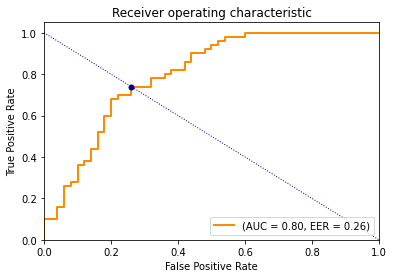

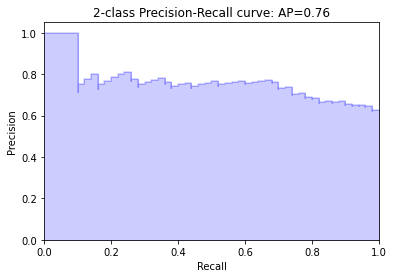

In [ ]:
# evaluating
ganomaly.evaluate_best(test_dataset)